In [13]:
# Clean Original Dataset (Remove all columns except: title, description, fraudulent)
# Import required libraries
import pandas as pd
import re
import string
from IPython.display import display

# Load dataset
file_path = "data/fake_job_postings.csv"
df = pd.read_csv(file_path)

#Keep only the relevant columns
selected_columns = ["title", "description", "fraudulent"]
df = df[selected_columns]

#Fill missing values
df["title"] = df["title"].fillna("")  # Fill missing job titles with empty string
df["description"] = df["description"].fillna("")  # Fill missing job descriptions with empty string

#Function to clean text
def clean_text(text):
    text = text.lower()  #Convert to lowercase
    text = re.sub(r"\d+", "", text)  #Remove numbers
    text = text.translate(str.maketrans("", "", string.punctuation))  #Remove punctuation
    return text.strip()

#Clean text columns
df["title"] = df["title"].apply(clean_text)
df["description"] = df["description"].apply(clean_text)

#Display cleaned dataset head
display(df.head())

#Save cleaned dataset as a new CSV file
df.to_csv("cleaned_fake_job_postings.csv", index=False)


Dataset after cleaning:
                                      title  \
0                          marketing intern   
1  customer service  cloud video production   
2     commissioning machinery assistant cma   
3          account executive  washington dc   
4                       bill review manager   

                                         description  fraudulent  
0  food a fastgrowing james beard awardwinning on...           0  
1  organised  focused  vibrant  awesomedo you hav...           0  
2  our client located in houston is actively seek...           0  
3  the company esri – environmental systems resea...           0  
4  job title itemization review managerlocation f...           0  
Cleaned dataset saved as 'cleaned_fake_job_postings.csv


,precision,recall,f1-score,support
0,0.983616,0.990280,0.986937,3395.000000
1,0.791139,0.690608,0.737463,181.000000
accuracy,0.975112,0.975112,0.975112,0.975112
macro avg,0.887378,0.840444,0.862200,3576.000000
weighted avg,0.973874,0.975112,0.974310,3576.000000


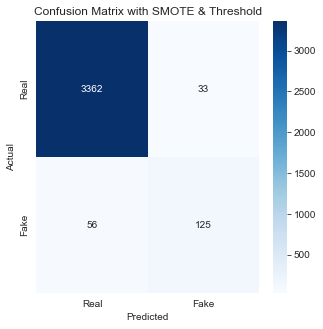

In [3]:
#Train Model
#Import required libraries
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from IPython.display import display

#Load the Cleaned Dataset
df = pd.read_csv("cleaned_fake_job_postings.csv")

#Fix Missing Values
df["title"].fillna("", inplace=True)
df["description"].fillna("", inplace=True)

#Convert Text Data into Numerical Features Using TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_text = vectorizer.fit_transform(df["title"] + " " + df["description"])

#Remove structured data (use only TF-IDF features)
X = X_text.toarray()

#Define Target Variable
y = df["fraudulent"]

#Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Apply SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

#Train Logistic Regression
model = LogisticRegression(max_iter=2000, solver="lbfgs")  # Updated for better convergence
model.fit(X_train_balanced, y_train_balanced)

#Get Probability Predictions
y_pred_probs = model.predict_proba(X_test)[:, 1]

#Apply the best threshold (0.55)
best_threshold = 0.55
y_pred_final = (y_pred_probs >= best_threshold).astype(int)

#Print Classification Report
report = classification_report(y_test, y_pred_final, output_dict=True)
display(pd.DataFrame(report).transpose())

#Plot Confusion Matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix with SMOTE & Threshold")
plt.show()


In [4]:
#User Interface
import ipywidgets as widgets
from IPython.display import display, clear_output

# Output widget for displaying results
output = widgets.Output()

# Function to preprocess user input (text-based only)
def preprocess_input(title, description):
    # Combine title and description
    text_input = title + " " + description

    # Transform input using trained TF-IDF vectorizer
    text_features = vectorizer.transform([text_input]).toarray()

    # Use only text-based features
    X_input = text_features

    # Predict probability
    prob = model.predict_proba(X_input)[0, 1]

    # Apply best threshold (0.55)
    prediction = "Fake Job Posting" if prob >= 0.55 else "Legitimate Job"

    return prediction, prob

#Create text inputs for title and description
title_input = widgets.Text(placeholder="Enter job title...", description="Title:")
description_input = widgets.Textarea(placeholder="Enter job description...", description="Description:")
predict_button = widgets.Button(description="Predict")

# Predict button event
def on_predict_clicked(b):
    with output:
        clear_output(wait=True)  # Clear previous output

        title = title_input.value.strip()
        description = description_input.value.strip()

        if not title or not description:
            print("Please enter both a job title and description.")
            return

        prediction, probability = preprocess_input(title, description)

        # Display results
        print(f"\n**Prediction:** {prediction}")
        print(f"**Fraud Probability:** {probability:.2f}")

#Attach the event to the button
predict_button.on_click(on_predict_clicked)

# Display input fields, button, and output
ui = widgets.VBox([title_input, description_input, predict_button, output])
display(ui)

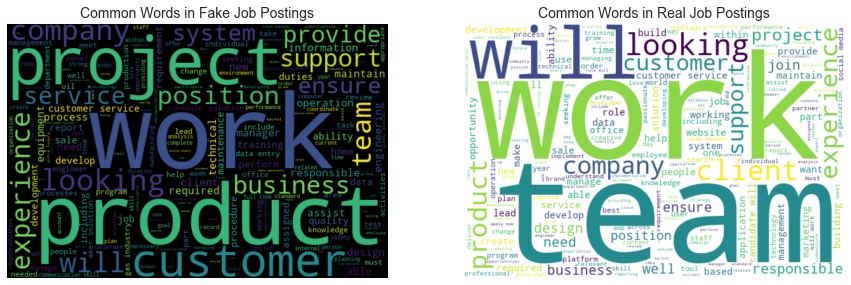

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Separate fake & real job postings
fake_jobs = df[df["fraudulent"] == 1]["description"].str.cat(sep=" ")
real_jobs = df[df["fraudulent"] == 0]["description"].str.cat(sep=" ")

# Generate word clouds
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

wordcloud_fake = WordCloud(width=600, height=400, background_color="black").generate(fake_jobs)
wordcloud_real = WordCloud(width=600, height=400, background_color="white").generate(real_jobs)

# Plot fake job word cloud
ax[0].imshow(wordcloud_fake, interpolation="bilinear")
ax[0].set_title("Common Words in Fake Job Postings", fontsize=14)
ax[0].axis("off")

# Plot real job word cloud
ax[1].imshow(wordcloud_real, interpolation="bilinear")
ax[1].set_title("Common Words in Real Job Postings", fontsize=14)
ax[1].axis("off")

plt.show()

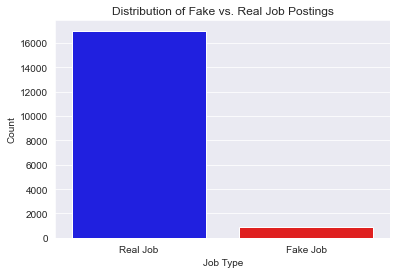

In [12]:
import seaborn as sns

# Count of fraudulent vs. legitimate job postings
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="fraudulent", palette=["blue", "red"])
plt.xticks([0, 1], ["Real Job", "Fake Job"])
plt.xlabel("Job Type")
plt.ylabel("Count")
plt.title("Distribution of Fake vs. Real Job Postings")
plt.show()

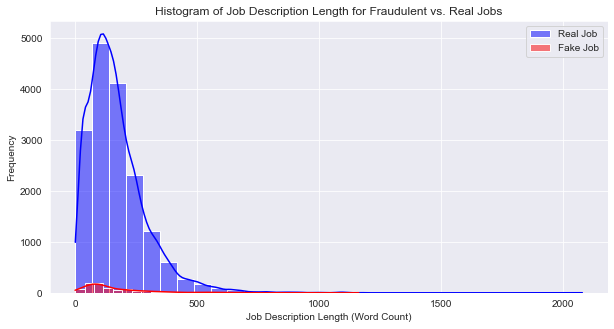

In [11]:
# Compute length of job descriptions
df["description_length"] = df["description"].apply(lambda x: len(x.split()))

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(df[df["fraudulent"] == 0]["description_length"], bins=30, color="blue", label="Real Job", kde=True)
sns.histplot(df[df["fraudulent"] == 1]["description_length"], bins=30, color="red", label="Fake Job", kde=True)
plt.legend()
plt.xlabel("Job Description Length (Word Count)")
plt.ylabel("Frequency")
plt.title("Histogram of Job Description Length for Fraudulent vs. Real Jobs")
plt.show()